# Imports and Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix

import ast
import json
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH = '../data/processed/search/aggregated_papers_with_search.csv'

In [3]:
data = pd.read_csv(PATH)
len(data)

200

In [4]:
# data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
data.head()

,paper_id,paper_title,paper_abstract,paper_acceptance,meta_review,label,review_ids,review_writers,review_contents,review_ratings,review_confidences,review_reply_tos,critique_points,meta_review_critique,SoTA Results,Combined Critiques,Retrieved Evidence
0,iclr_2022_jaLDP8Hp_gc,Visual Correspondence Hallucination,Given a pair of partially overlapping source a...,Accept (Poster),This paper receives positive reviews. The auth...,train,"['EkXSobQaGSX', 't_m188ir-01', 'aB-aAw0xvHi', ...","['author', 'official_reviewer', 'official_revi...","[' Thank you for your reply, please find our r...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, 8, 5, 8]","[-1, -1, -1, -1, -1, -1, -1, -1, -1, 4, 4, 3]","['9MQG_FP3eQB', 'Lv3RrS-8N1T', 'F5nhRjo6xc', '...","[{'Methodology': [], 'Experiments': [], 'Clari...","{'Methodology': [], 'Experiments': [], 'Clarit...","""Act Like a Radiologist: Towards Reliable Mult...",{'Methodology': 'Enhance the baseline with a g...,{'Methodology': 'Finding specific papers that ...
1,iclr_2019_B1xsqj09Fm,Large Scale GAN Training for High Fidelity Nat...,Despite recent progress in generative image mo...,accepted-oral-papers,The paper proposes a set of tricks leading to ...,train,"['SJl68_Hx37', 'SkgkCbBm0Q', 'Syxd9-HXAQ', 'r1...","['official_reviewer', 'author', 'author', 'aut...",['This paper present extensions of the Self-At...,"[9, -1, -1, -1, -1, -1, 7, 8, -1, -1, -1, -1, ...","[4, -1, -1, -1, -1, -1, 3, 4, -1, -1, -1, -1, ...","['iclr_2019_B1xsqj09Fm', 'SJl68_Hx37', 'r1gI_-...",[{'Methodology': ['Increasing the batch size b...,"{'Methodology': [], 'Experiments': [], 'Clarit...","Recent research related to ""Large Scale GAN Tr...","{'Methodology': ""Increasing the batch size by ...","{'Methodology': ""Based on the searches, here's..."
2,iclr_2020_BJeXaJHKvB,P-BN: Towards Effective Batch Normalization in...,Neural networks with ReLU activation functions...,reject,This paper addresses the extension of path-spa...,train,"['HygQZEdrir', 'BygbSE_riH', 'BJl__VdBiH', 'ry...","['author', 'author', 'author', 'author', 'offi...",['Thank you for your comments. The following i...,"[-1, -1, -1, -1, 3, 3, 3]","[-1, -1, -1, -1, 4, 4, 1]","['ryeSKamyoB', 'HkxkpF_j5S', 'r1leWJ7TYr', 'ic...",[{'Methodology': ['The paper does not motivate...,{'Methodology': ['The paper extends path-space...,"The paper ""Path-BN: Towards effective batch no...",{'Methodology': 'The paper does not motivate t...,"{'Methodology': ""The provided research papers ..."
3,nips_2022_2ge7_pORL_n,BiMLP: Compact Binary Architectures for Vision...,This paper studies the problem of designing co...,Accept,Four reviewers provided feedback on this paper...,train,"['j0xSlomDUSe', 'KBmpimZpkQD', 'O4eCZ0ts34E', ...","['official_reviewer', 'official_reviewer', 'of...","["" Thanks for your response. I don't have more...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 4, 5,...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 4, 3,...","['lMqMcmUp-1O', 'PDLVUcRKcB3', 'Smfma6uKX7F', ...","[{'Methodology': [], 'Experiments': [], 'Clari...","{'Methodology': [], 'Experiments': ['The appro...",I was unable to find specific papers citing th...,"{'Methodology': ""The author is suggested to ad...",{'Methodology': 'After conducting several sear...
4,iclr_2018_SyVVXngRW,Deep Asymmetric Multi-task Feature Learning,We propose Deep Asymmetric Multitask Feature L...,rejected-papers,The paper proposes a multitask deep learning m...,train,"['ryAf2-ugz', 'H11NN0KgG', 'S1T4ik9ef']","['official_reviewer', 'official_reviewer', 'of...","[""This paper presents a deep asymmetric multi-...","[6, 3, 5]","[4, 4, 4]","['iclr_2018_SyVVXngRW', 'iclr_2018_SyVVXngRW',...","[{'Methodology': [], 'Experiments': ['In real-...","{'Methodology': [], 'Experiments': ['limited e...",Two recent papers that appear relevant based o...,{'Methodology': 'Matrix B in Eq.(4) and Matrix...,{'Methodology': 'Several research papers provi...


In [5]:
data.isna().sum()

paper_id                0
paper_title             0
paper_abstract          0
paper_acceptance        0
meta_review             0
label                   0
review_ids              0
review_writers          0
review_contents         0
review_ratings          0
review_confidences      0
review_reply_tos        0
critique_points         0
meta_review_critique    2
SoTA Results            0
Combined Critiques      0
Retrieved Evidence      1
dtype: int64

In [6]:
data[data['meta_review_critique'].isna()]

,paper_id,paper_title,paper_abstract,paper_acceptance,meta_review,label,review_ids,review_writers,review_contents,review_ratings,review_confidences,review_reply_tos,critique_points,meta_review_critique,SoTA Results,Combined Critiques,Retrieved Evidence
31,iclr_2020_r1eBeyHFDH,A Theory of Usable Information under Computati...,We propose a new framework for reasoning about...,accept-talk,All reviewers unanimously accept the paper.,train,"['S1lklsZcor', 'Sket3aNBoB', 'Bkx9phEroS', 'ry...","['official_reviewer', 'author', 'author', 'off...",['Thank you for addressing all issues raised i...,"[-1, -1, -1, 8, 8]","[-1, -1, -1, 3, 4]","['Bkx9phEroS', 'r1eqrvhf5S', 'ryl1OrQ0KS', 'ic...","[{'Methodology': [], 'Experiments': [], 'Clari...",NaN,"The latest research related to ""A Theory of Us...",{'Methodology': 'The paper proposes a framewor...,"{'Methodology': 'Research papers such as ""Beyo..."
72,iclr_2020_r1ecqn4YwB,N-BEATS: Neural basis expansion analysis for i...,We focus on solving the univariate times serie...,accept-poster,The paper received positive recommendation fro...,train,"['HkxhvW1H5S', 'SJghIrYk9r', 'B1xVpwzUiB', 'Hk...","['official_reviewer', 'official_reviewer', 'au...",['The paper proposes a DL architecture that ac...,"[6, 8, -1, -1, -1, -1, -1, -1, -1, -1, 6]","[3, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1]","['iclr_2020_r1ecqn4YwB', 'iclr_2020_r1ecqn4YwB...",[{'Methodology': ['The paper proposes a DL arc...,NaN,The latest state-of-the-art research related t...,{'Methodology': 'The paper proposes a DL archi...,NaN


In [7]:
data = data.dropna(subset=['meta_review_critique'])

In [8]:
data.isna().sum()

paper_id                0
paper_title             0
paper_abstract          0
paper_acceptance        0
meta_review             0
label                   0
review_ids              0
review_writers          0
review_contents         0
review_ratings          0
review_confidences      0
review_reply_tos        0
critique_points         0
meta_review_critique    0
SoTA Results            0
Combined Critiques      0
Retrieved Evidence      0
dtype: int64

In [9]:
len(data)

198

In [10]:
data.nunique()

paper_id                198
paper_title             198
paper_abstract          198
paper_acceptance         16
meta_review             198
label                     1
review_ids              198
review_writers          154
review_contents         198
review_ratings          194
review_confidences      193
review_reply_tos        198
critique_points         198
meta_review_critique    190
SoTA Results            197
Combined Critiques      198
Retrieved Evidence      198
dtype: int64

In [11]:
retrieved_data = data[['paper_title', 'SoTA Results', 'Combined Critiques', 'Retrieved Evidence']]
retrieved_data.head()

,paper_title,SoTA Results,Combined Critiques,Retrieved Evidence
0,Visual Correspondence Hallucination,"""Act Like a Radiologist: Towards Reliable Mult...",{'Methodology': 'Enhance the baseline with a g...,{'Methodology': 'Finding specific papers that ...
1,Large Scale GAN Training for High Fidelity Nat...,"Recent research related to ""Large Scale GAN Tr...","{'Methodology': ""Increasing the batch size by ...","{'Methodology': ""Based on the searches, here's..."
2,P-BN: Towards Effective Batch Normalization in...,"The paper ""Path-BN: Towards effective batch no...",{'Methodology': 'The paper does not motivate t...,"{'Methodology': ""The provided research papers ..."
3,BiMLP: Compact Binary Architectures for Vision...,I was unable to find specific papers citing th...,"{'Methodology': ""The author is suggested to ad...",{'Methodology': 'After conducting several sear...
4,Deep Asymmetric Multi-task Feature Learning,Two recent papers that appear relevant based o...,{'Methodology': 'Matrix B in Eq.(4) and Matrix...,{'Methodology': 'Several research papers provi...


-----

# Analysis of SoTA Results, Combined Critiques, Retrieved Evidence

## SoTA paper results vs Real paper title

In [12]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [13]:
retrieved_data["title_embedding"] = retrieved_data["paper_title"].apply(lambda x: model.encode(x))
retrieved_data["sota_embedding"] = retrieved_data["SoTA Results"].apply(lambda x: model.encode(x))

retrieved_data["sota_title_similarity"] = retrieved_data.apply(lambda row: cosine_similarity(
    [row["title_embedding"]], [row["sota_embedding"]]
)[0][0], axis=1)

In [14]:
retrieved_data.head()

,paper_title,SoTA Results,Combined Critiques,Retrieved Evidence,title_embedding,sota_embedding,sota_title_similarity
0,Visual Correspondence Hallucination,"""Act Like a Radiologist: Towards Reliable Mult...",{'Methodology': 'Enhance the baseline with a g...,{'Methodology': 'Finding specific papers that ...,"[0.009022671, -0.023608789, 0.02555041, -0.037...","[0.0048284433, -0.023370659, -0.035465695, -0....",0.580911
1,Large Scale GAN Training for High Fidelity Nat...,"Recent research related to ""Large Scale GAN Tr...","{'Methodology': ""Increasing the batch size by ...","{'Methodology': ""Based on the searches, here's...","[-0.029692411, -0.07702128, 0.04208037, 0.0354...","[-0.09327985, -0.06305527, 0.059310846, -0.000...",0.696837
2,P-BN: Towards Effective Batch Normalization in...,"The paper ""Path-BN: Towards effective batch no...",{'Methodology': 'The paper does not motivate t...,"{'Methodology': ""The provided research papers ...","[-0.033532735, -0.03762548, 0.017242817, 0.007...","[-0.061469387, -0.069011174, 0.01439231, 0.014...",0.799690
3,BiMLP: Compact Binary Architectures for Vision...,I was unable to find specific papers citing th...,"{'Methodology': ""The author is suggested to ad...",{'Methodology': 'After conducting several sear...,"[0.021225171, -0.07354029, 0.022575952, -0.069...","[-0.035298217, -0.015040423, 0.003722904, -0.0...",0.754688
4,Deep Asymmetric Multi-task Feature Learning,Two recent papers that appear relevant based o...,{'Methodology': 'Matrix B in Eq.(4) and Matrix...,{'Methodology': 'Several research papers provi...,"[-0.03522529, -0.06418738, 0.011596794, 0.0214...","[-0.07198505, -0.09096402, 0.033543807, 0.0798...",0.550488


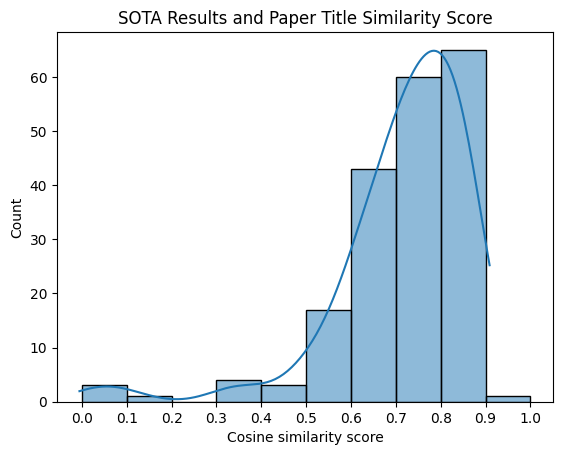

In [15]:
sns.histplot(data=retrieved_data, x='sota_title_similarity', kde=True, bins=10, binrange=(0, 1))
plt.xticks(np.arange(0, 1.01, 0.1))
plt.title('SOTA Results and Paper Title Similarity Score')
plt.xlabel('Cosine similarity score')
plt.show()

## Converting to proper JSON format

In [16]:
retrieved_data['Combined Critiques'][0]

'{\'Methodology\': \'Enhance the baseline with a geometric perspective using homography estimation and keypoint mapping, considering assumptions about scene depth variance and keypoint availability. It is unclear what the network actually learns. The description of the warping process and the correspondence map is not clear enough. The metrics used for evaluation are somewhat arbitrary or not sufficiently justified. For example, comparing results to random chance is a weak baseline. The translation error threshold is uninformative without knowing the magnitude of the translation between the cameras. The method is based on correspondence map and neural reprojection error. Limited technique contribution as the method adapts [Germain 2021]. The paper introduces a new model and training paradigm for hallucinating correspondence by predicting the probability distribution of its location. Authors should define how to compute Kc for transforming points from the image plane to the corresponden

In [17]:
retrieved_data['Retrieved Evidence'][0]

'{\'Methodology\': \'Finding specific papers that *directly* critique the methodology as described with the exact wording is difficult. However, the search has revealed papers that address the *underlying concerns* of those critiques.\\n*   **Scene Depth Variance and Keypoint Availability:** "Deep Homography Estimation for Dynamic Scenes" directly tackles the issue of dynamic content, a major source of scene depth variance. Furthermore, papers on unsupervised learning ("Unsupervised Deep Homography: A Fast and Robust Homography Estimation Model" and "Content-aware Unsupervised Deep Homography Estimation") offer alternative training methods that might reduce reliance on strong scene assumptions and keypoint availability.\\n*   **Warping Process Clarity:** "Warped Convolutional Networks: Bridge Homography to sl(3) algebra by Group Convolution" takes a theoretical approach to the warping process, which might help clarify its mathematical underpinnings.\\n*   **Evaluation Metrics:** "A Lar

In [18]:
def parse_combined_critiques(critique_string):
    try:
        critique_dict = ast.literal_eval(critique_string)
        
        json_data = json.dumps(critique_dict, indent=4)
        
        return json.loads(json_data)
    except (SyntaxError, ValueError) as e:
        print(f"Error parsing critique string: {e}")
        return None

In [19]:
tqdm.pandas()

retrieved_data["parsed_critiques"] = retrieved_data["Combined Critiques"].progress_apply(parse_combined_critiques)
retrieved_data["parsed_evidences"] = retrieved_data["Retrieved Evidence"].progress_apply(parse_combined_critiques)

retrieved_data.head()


  0%|          | 0/198 [00:00<?, ?it/s]

100%|██████████| 198/198 [00:00<00:00, 5047.97it/s]


,paper_title,SoTA Results,Combined Critiques,Retrieved Evidence,title_embedding,sota_embedding,sota_title_similarity,parsed_critiques,parsed_evidences
0,Visual Correspondence Hallucination,"""Act Like a Radiologist: Towards Reliable Mult...",{'Methodology': 'Enhance the baseline with a g...,{'Methodology': 'Finding specific papers that ...,"[0.009022671, -0.023608789, 0.02555041, -0.037...","[0.0048284433, -0.023370659, -0.035465695, -0....",0.580911,{'Methodology': 'Enhance the baseline with a g...,{'Methodology': 'Finding specific papers that ...
1,Large Scale GAN Training for High Fidelity Nat...,"Recent research related to ""Large Scale GAN Tr...","{'Methodology': ""Increasing the batch size by ...","{'Methodology': ""Based on the searches, here's...","[-0.029692411, -0.07702128, 0.04208037, 0.0354...","[-0.09327985, -0.06305527, 0.059310846, -0.000...",0.696837,{'Methodology': 'Increasing the batch size by ...,"{'Methodology': 'Based on the searches, here's..."
2,P-BN: Towards Effective Batch Normalization in...,"The paper ""Path-BN: Towards effective batch no...",{'Methodology': 'The paper does not motivate t...,"{'Methodology': ""The provided research papers ...","[-0.033532735, -0.03762548, 0.017242817, 0.007...","[-0.061469387, -0.069011174, 0.01439231, 0.014...",0.799690,{'Methodology': 'The paper does not motivate t...,{'Methodology': 'The provided research papers ...
3,BiMLP: Compact Binary Architectures for Vision...,I was unable to find specific papers citing th...,"{'Methodology': ""The author is suggested to ad...",{'Methodology': 'After conducting several sear...,"[0.021225171, -0.07354029, 0.022575952, -0.069...","[-0.035298217, -0.015040423, 0.003722904, -0.0...",0.754688,{'Methodology': 'The author is suggested to ad...,{'Methodology': 'After conducting several sear...
4,Deep Asymmetric Multi-task Feature Learning,Two recent papers that appear relevant based o...,{'Methodology': 'Matrix B in Eq.(4) and Matrix...,{'Methodology': 'Several research papers provi...,"[-0.03522529, -0.06418738, 0.011596794, 0.0214...","[-0.07198505, -0.09096402, 0.033543807, 0.0798...",0.550488,{'Methodology': 'Matrix B in Eq.(4) and Matrix...,{'Methodology': 'Several research papers provi...


In [20]:
retrieved_data['parsed_critiques'][0]

{'Methodology': 'Enhance the baseline with a geometric perspective using homography estimation and keypoint mapping, considering assumptions about scene depth variance and keypoint availability. It is unclear what the network actually learns. The description of the warping process and the correspondence map is not clear enough. The metrics used for evaluation are somewhat arbitrary or not sufficiently justified. For example, comparing results to random chance is a weak baseline. The translation error threshold is uninformative without knowing the magnitude of the translation between the cameras. The method is based on correspondence map and neural reprojection error. Limited technique contribution as the method adapts [Germain 2021]. The paper introduces a new model and training paradigm for hallucinating correspondence by predicting the probability distribution of its location. Authors should define how to compute Kc for transforming points from the image plane to the correspondence p

In [21]:
retrieved_data['parsed_evidences'][0]

{'Methodology': 'Finding specific papers that *directly* critique the methodology as described with the exact wording is difficult. However, the search has revealed papers that address the *underlying concerns* of those critiques.\n*   **Scene Depth Variance and Keypoint Availability:** "Deep Homography Estimation for Dynamic Scenes" directly tackles the issue of dynamic content, a major source of scene depth variance. Furthermore, papers on unsupervised learning ("Unsupervised Deep Homography: A Fast and Robust Homography Estimation Model" and "Content-aware Unsupervised Deep Homography Estimation") offer alternative training methods that might reduce reliance on strong scene assumptions and keypoint availability.\n*   **Warping Process Clarity:** "Warped Convolutional Networks: Bridge Homography to sl(3) algebra by Group Convolution" takes a theoretical approach to the warping process, which might help clarify its mathematical underpinnings.\n*   **Evaluation Metrics:** "A Large-Scal

## Exploring Critiques and Evidences thoroughly

In [22]:
critiques_df = pd.json_normalize(retrieved_data["parsed_critiques"])
evidences_df = pd.json_normalize(retrieved_data["parsed_evidences"])

In [23]:
critiques_df.head()

,Methodology,Clarity,Experiments,Significance,Novelty
0,Enhance the baseline with a geometric perspect...,The updated versions is better for illustratio...,Show results for identified keypoints in Figur...,The proposed method is able to predict the loc...,The technical contribution is sufficient This ...
1,Increasing the batch size by a factor 8. Augme...,Clarification of the truncation trick: if the ...,Variations of the threshold lead to variations...,Impressive images generations conditioned on i...,The core novel element of the paper is the tru...
2,The paper does not motivate this type of regul...,The statement of Theorem 3.1 is unclear. The o...,Empirical results show better performance with...,The paper's main contribution (P-BN) lacks suf...,The motivation of novel batch-normalization to...
3,The author is suggested to add the theoretical...,The paper is not well organized. Two many prel...,The proposed is only validated on one dataset....,The devised new framework is not useful. The c...,"Overall, the novelty of the proposed method is..."
4,Matrix B in Eq.(4) and Matrix A in Eq.(6) are ...,The last sentence in page 3 is incomplete. Unc...,"In real-world experiments, it is better to sho...","The paper conflates the concepts of noisy, unr...",The large similarity with AMTL decreases the n...


In [24]:
critiques_df.isna().sum()

Methodology     0
Clarity         0
Experiments     0
Significance    0
Novelty         0
dtype: int64

In [25]:
evidences_df.head()

,Methodology,Clarity,Experiments,Significance,Novelty
0,Finding specific papers that *directly* critiq...,"The paper ""Explore the Hallucination on Low-le...","Based on the searches, here's a summary of res...","Based on the searches, several research papers...",I am unable to provide a definitive answer bas...
1,"Based on the searches, here's a summary of res...",I was unable to find research papers that spec...,"Based on the search results, some papers chall...","""A note on the inception score"" by Barratt and...","* ""Exploring and Exploiting Hubness Priors f..."
2,The provided research papers address the limit...,It's difficult to find specific papers that di...,While I couldn't find a single paper that dire...,Several research papers discuss the limitation...,"Based on the search results, here are some pot..."
3,"After conducting several searches on ArXiv, I ...",The critiques you provided touch upon key aspe...,I have found research papers that support or c...,I found several papers discussing the topics r...,"Based on the search results, it's challenging ..."
4,Several research papers provide context releva...,"The research paper in question is likely ""Deep...","Based on the search results, I found evidence ...","Based on the searches, the following papers ar...",Combining existing machine learning methods ca...


In [26]:
evidences_df.isna().sum()

Methodology     2
Clarity         1
Experiments     0
Significance    2
Novelty         0
dtype: int64

In [27]:
evidences_df.fillna('No information available.', inplace=True)

In [28]:
evidences_df.isna().sum()

Methodology     0
Clarity         0
Experiments     0
Significance    0
Novelty         0
dtype: int64

----

## Sub columns similarity scores

In [29]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

sections = critiques_df.columns

similarity_df = pd.DataFrame()

for section in tqdm(sections):
    critiques_df[f"{section}_embedding"] = critiques_df[section].apply(lambda x: model.encode(str(x)))
    evidences_df[f"{section}_embedding"] = evidences_df[section].apply(lambda x: model.encode(str(x)))

    similarity_df[f"{section}_similarity"] = critiques_df.apply(lambda row: cosine_similarity(
        [row[f"{section}_embedding"]], 
        [evidences_df.loc[row.name, f"{section}_embedding"]]
    )[0][0], axis=1)

similarity_df.head()

100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


,Methodology_similarity,Clarity_similarity,Experiments_similarity,Significance_similarity,Novelty_similarity
0,0.657057,0.310692,0.775674,0.782802,0.016654
1,0.741479,0.341947,0.376597,0.543075,0.653649
2,0.736995,0.598823,0.689204,0.348741,0.590000
3,0.639003,0.566969,0.299842,0.493697,0.021027
4,0.604410,0.519360,0.389137,0.487145,0.327868


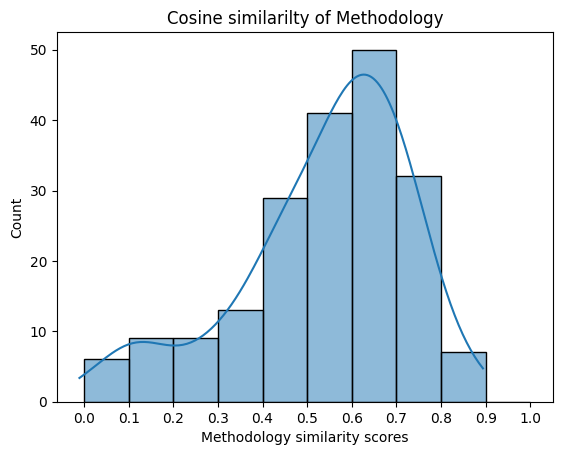

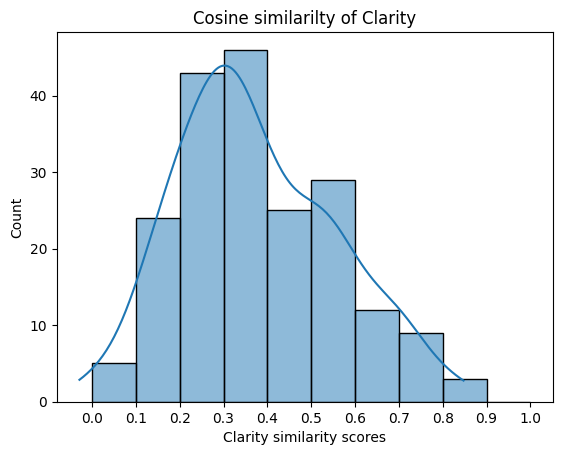

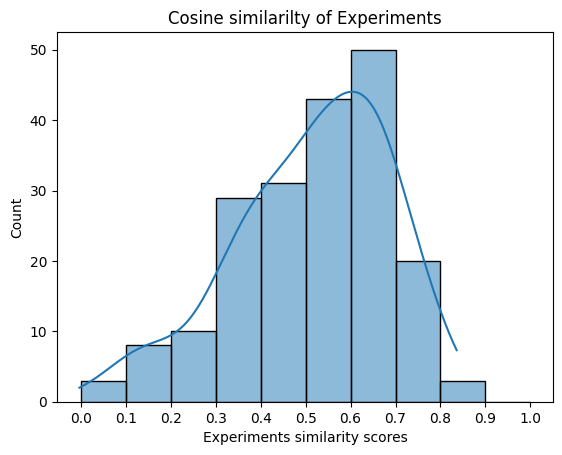

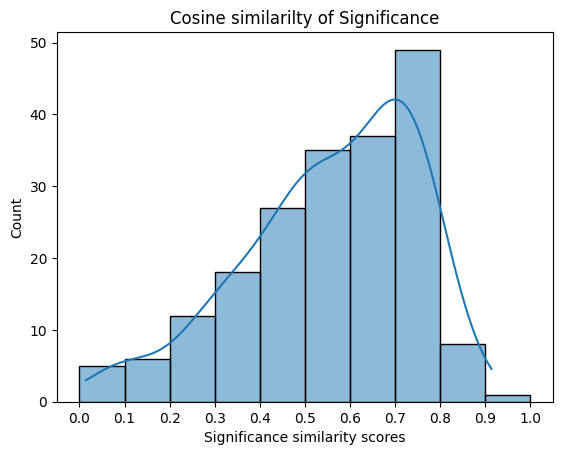

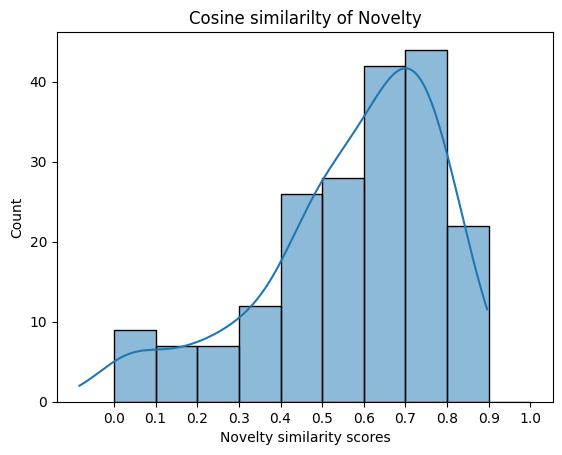

In [30]:
for col in similarity_df.columns:
    sns.histplot(data=similarity_df, x=col, kde=True, bins=10, binrange=(0, 1))
    plt.title(f'Cosine similarilty of {col.split("_")[0]}')
    plt.xticks(np.arange(0, 1.01, 0.1))
    plt.xlabel(f"{col.split('_')[0]} similarity scores")
    plt.show()

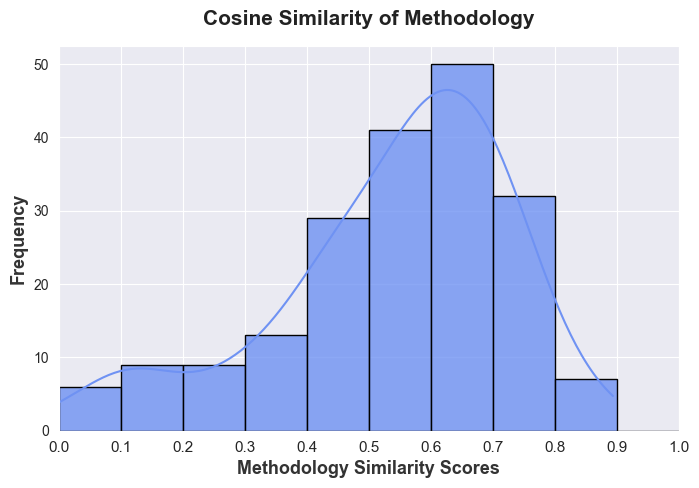

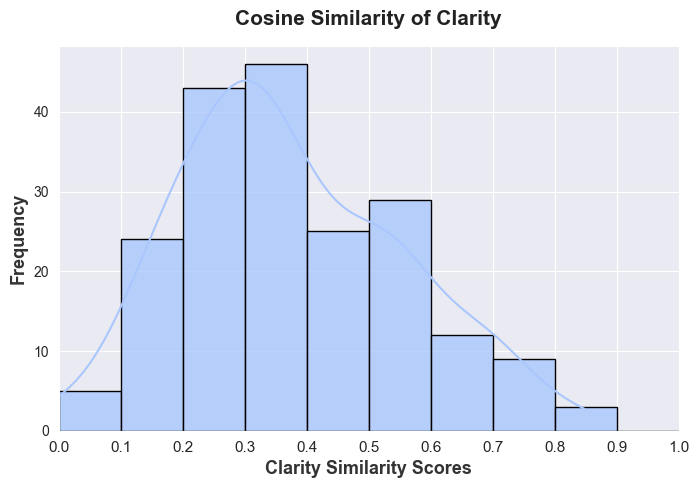

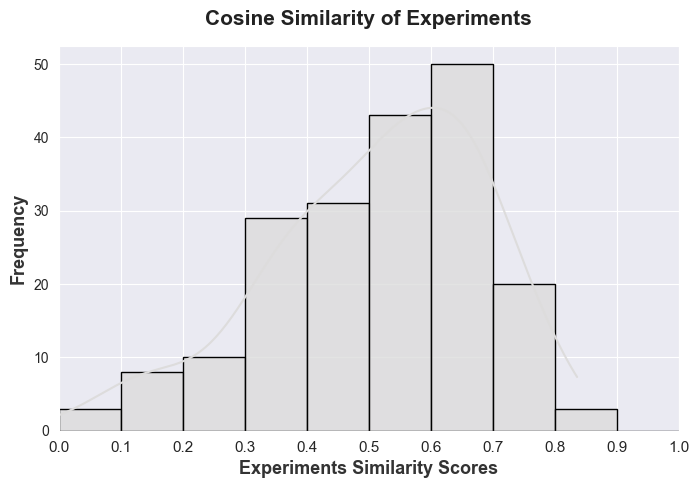

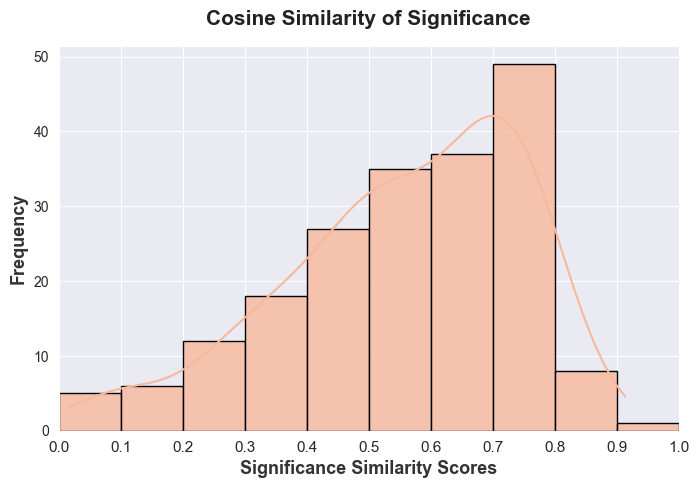

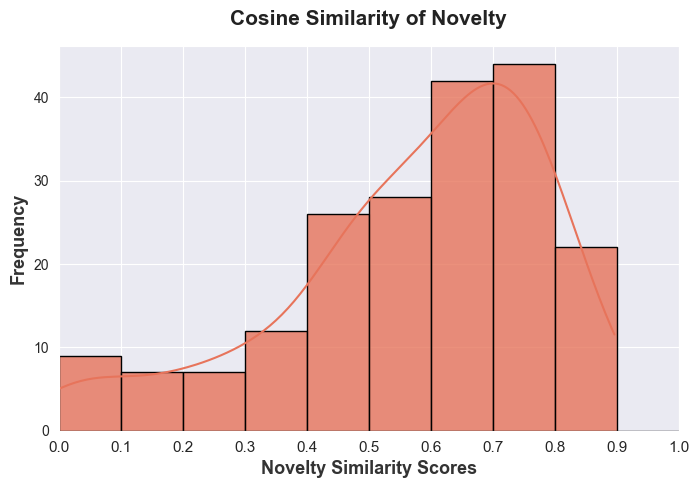

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set Seaborn style
sns.set_style("darkgrid")

# Define a color palette
colors = sns.color_palette("coolwarm", len(similarity_df.columns))

# Iterate through columns and plot histograms
for i, col in enumerate(similarity_df.columns):
    plt.figure(figsize=(8, 5))  # Larger figure size

    # Histogram plot with KDE
    sns.histplot(data=similarity_df, x=col, kde=True, bins=10, binrange=(0, 1), 
                 color=colors[i], edgecolor="black", alpha=0.8)

    # Formatting labels and title
    plt.title(f'Cosine Similarity of {col.split("_")[0]}', fontsize=15, fontweight="bold", color="#222222", pad=15)
    plt.xlabel(f"{col.split('_')[0]} Similarity Scores", fontsize=13, fontweight="bold", color="#333333")
    plt.ylabel("Frequency", fontsize=13, fontweight="bold", color="#333333")

    # Customize x-ticks
    plt.xticks(np.arange(0, 1.01, 0.1), fontsize=11)
    plt.xlim(0, 1)  # Ensure limits are always 0 to 1

    # Show plot
    plt.show()

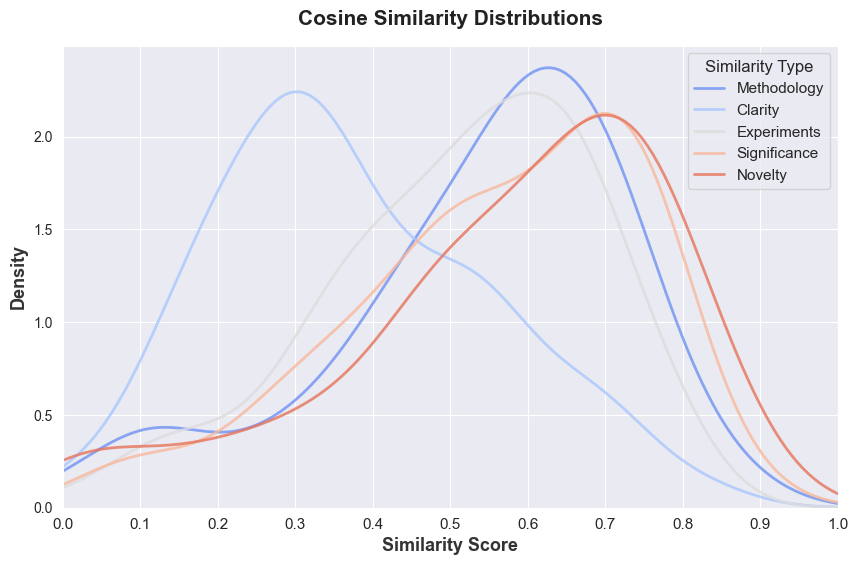

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set Seaborn style
sns.set_style("darkgrid")

# Define a color palette
colors = sns.color_palette("coolwarm", len(similarity_df.columns))

# Create a larger figure
plt.figure(figsize=(10, 6))

# Loop through each column and plot KDE on the same figure
for i, col in enumerate(similarity_df.columns):
    sns.kdeplot(similarity_df[col], color=colors[i], linewidth=2, label=col.split("_")[0], alpha=0.8)

# Formatting labels and title
plt.title("Cosine Similarity Distributions", fontsize=15, fontweight="bold", color="#222222", pad=15)
plt.xlabel("Similarity Score", fontsize=13, fontweight="bold", color="#333333")
plt.ylabel("Density", fontsize=13, fontweight="bold", color="#333333")

# Customize x-ticks
plt.xticks(np.arange(0, 1.01, 0.1), fontsize=11)
plt.xlim(0, 1)  # Ensure limits are always 0 to 1

# Add a legend
plt.legend(title="Similarity Type", fontsize=11, title_fontsize=12)

# Show the plot
plt.show()

-----

# Jaccard Similarity - overlapping words between critique and evidence.

In [33]:
jaccard_sim_df = pd.DataFrame()

In [34]:
def jaccard_similarity(text1, text2):
    words1 = set(text1.lower().split())
    words2 = set(text2.lower().split())
    return len(words1 & words2) / len(words1 | words2)

In [35]:
for section in tqdm(sections):
    jaccard_sim_df[section] = critiques_df.apply(
        lambda row: jaccard_similarity(row[section], evidences_df.loc[row.name, section]),
        axis=1
    )
jaccard_sim_df.head()

100%|██████████| 5/5 [00:00<00:00, 22.95it/s]


,Methodology,Clarity,Experiments,Significance,Novelty
0,0.137931,0.090909,0.208696,0.141844,0.076923
1,0.217617,0.029851,0.028409,0.111111,0.114286
2,0.146853,0.111940,0.090909,0.070175,0.070513
3,0.125000,0.106557,0.068182,0.090909,0.086957
4,0.106667,0.117647,0.115385,0.120370,0.122807


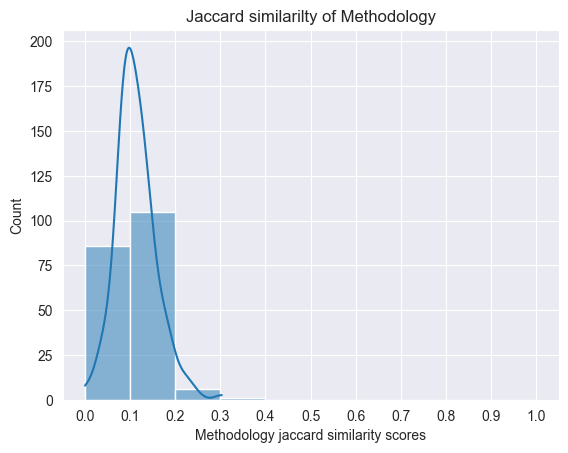

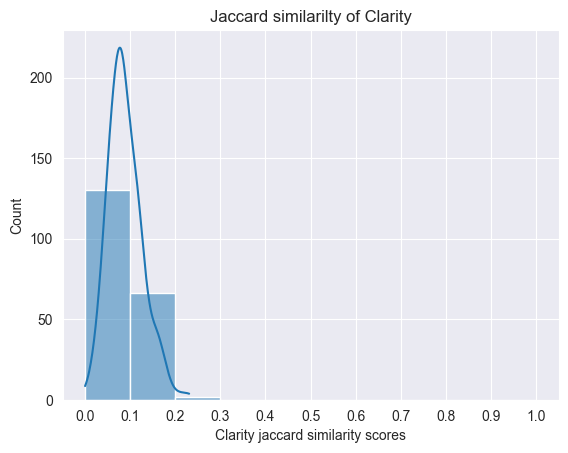

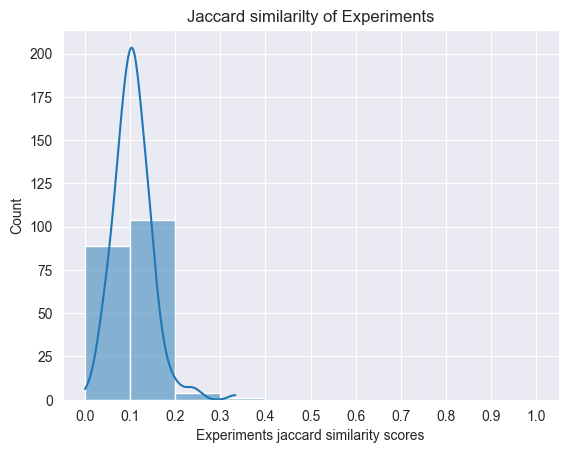

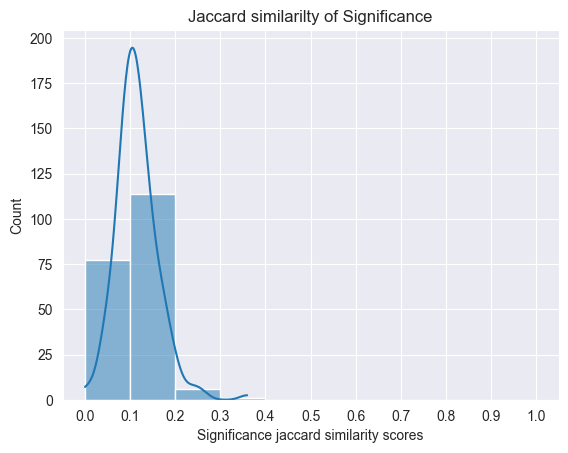

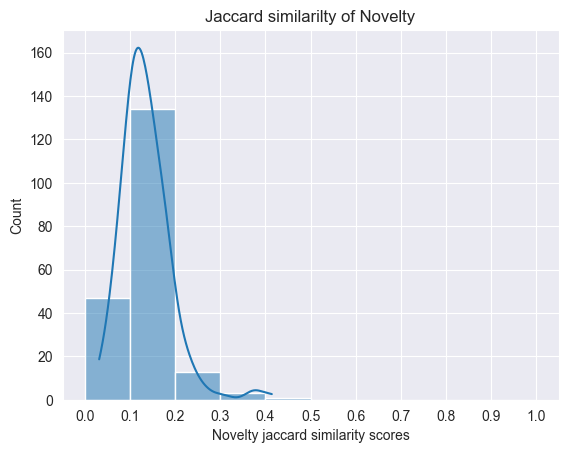

In [36]:
for col in jaccard_sim_df.columns:
    sns.histplot(data=jaccard_sim_df, x=col, kde=True, bins=10, binrange=(0, 1))
    plt.title(f'Jaccard similarilty of {col}')
    plt.xticks(np.arange(0, 1.01, 0.1))
    plt.xlabel(f"{col} jaccard similarity scores")
    plt.show()

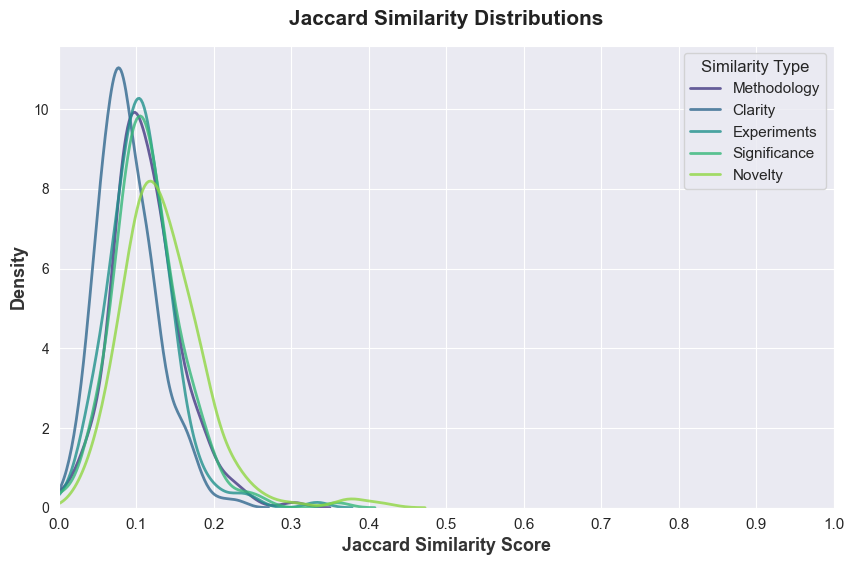

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set Seaborn style
sns.set_style("darkgrid")

# Define a color palette
colors = sns.color_palette("viridis", len(jaccard_sim_df.columns))

# Create a larger figure
plt.figure(figsize=(10, 6))

# Loop through each column and plot KDE on the same figure
for i, col in enumerate(jaccard_sim_df.columns):
    sns.kdeplot(jaccard_sim_df[col], color=colors[i], linewidth=2, label=col, alpha=0.8)

# Formatting labels and title
plt.title("Jaccard Similarity Distributions", fontsize=15, fontweight="bold", color="#222222", pad=15)
plt.xlabel("Jaccard Similarity Score", fontsize=13, fontweight="bold", color="#333333")
plt.ylabel("Density", fontsize=13, fontweight="bold", color="#333333")

# Customize x-ticks
plt.xticks(np.arange(0, 1.01, 0.1), fontsize=11)
plt.xlim(0, 1)  # Ensure limits are always 0 to 1

# Add a legend
plt.legend(title="Similarity Type", fontsize=11, title_fontsize=12)

# Show the plot
plt.show()

------

# Tone analysis - do both have similar tone?
* Small difference → Evidence and critique are aligned in tone.
* Large difference → Potential mismatch.

In [35]:
%pip install --quiet textblob

Note: you may need to restart the kernel to use updated packages.


In [36]:
from textblob import TextBlob

def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity 

In [37]:
tone_df = pd.DataFrame()

In [38]:
for section in tqdm(sections):
    tone_df[f'Critiques_{section}'] = critiques_df[section].apply(analyze_sentiment)
    tone_df[f'Evidences_{section}'] = evidences_df[section].apply(analyze_sentiment)

    tone_df[section] = abs(tone_df[f'Critiques_{section}'] - tone_df[f'Evidences_{section}'])

tone_df[sections].head()

100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


,Methodology,Clarity,Experiments,Significance,Novelty
0,0.086201,0.062500,0.069582,0.327219,0.275186
1,0.160582,0.202941,0.215417,0.332262,0.069524
2,0.084751,0.022511,0.131805,0.072068,0.052197
3,0.044792,0.032222,0.078354,0.022967,0.115285
4,0.077646,0.088333,0.233869,0.431571,0.267857


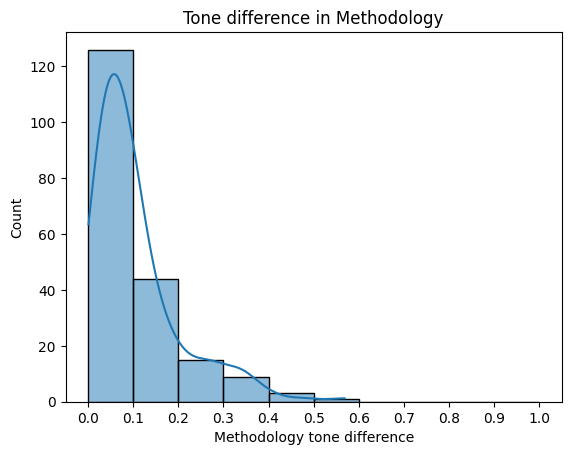

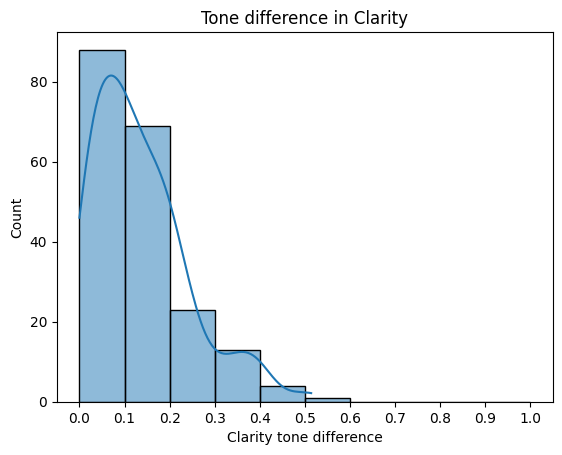

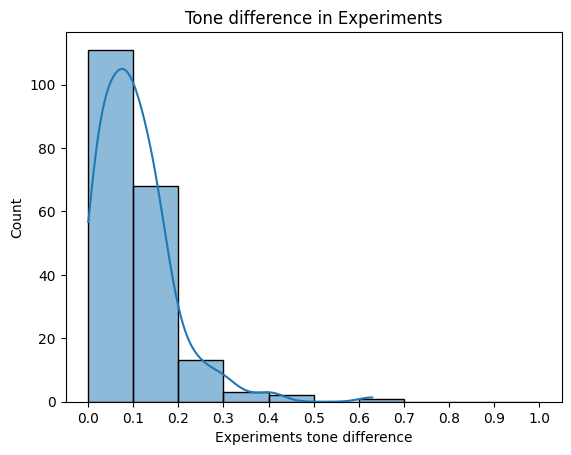

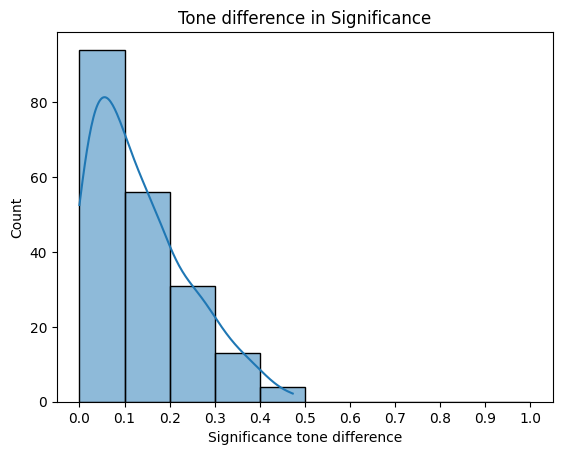

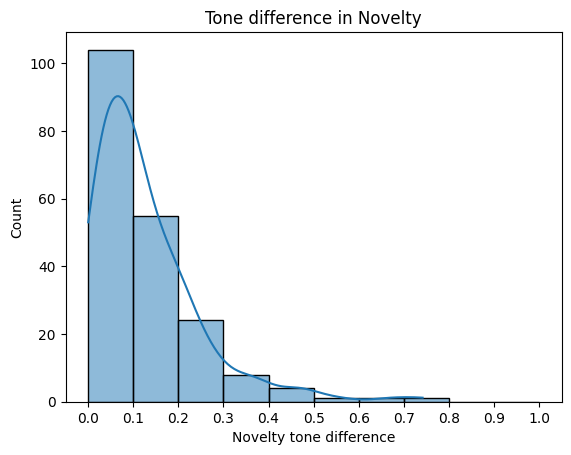

In [39]:
for col in sections:
    sns.histplot(data=tone_df, x=col, kde=True, bins=10, binrange=(0, 1))
    plt.title(f'Tone difference in {col}')
    plt.xticks(np.arange(0, 1.01, 0.1))
    plt.xlabel(f"{col} tone difference")
    plt.show()

------

# Sentiment Analysis - Do both share same sentiment?

In [40]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [41]:
def get_sentiment(text):
    if not isinstance(text, str):
        return "Neutral", 0.0
    score = sia.polarity_scores(text)['compound']
    if score >= 0.5:
        sentiment = "Positive"
    elif score <= -0.5:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    
    return sentiment, score

In [42]:
sentiment_results_critiques = critiques_df.iloc[:, :5].applymap(get_sentiment)
sentiment_results_evidences = evidences_df.iloc[:, :5].applymap(get_sentiment)

In [43]:
sentiment_critiques = sentiment_results_critiques.applymap(lambda x: x[0]) 
scores_critiques = sentiment_results_critiques.applymap(lambda x: x[1]) 

sentiment_evidences = sentiment_results_evidences.applymap(lambda x: x[0])
scores_evidences = sentiment_results_evidences.applymap(lambda x: x[1])

In [44]:
sentiment_critiques.columns = [col + "_sentiment" for col in critiques_df.columns[:5]]
scores_critiques.columns = [col + "_score" for col in critiques_df.columns[:5]]

sentiment_evidences.columns = [col + "_sentiment" for col in evidences_df.columns[:5]]
scores_evidences.columns = [col + "_score" for col in evidences_df.columns[:5]]

In [45]:
sentiment_critiques.head()

,Methodology_sentiment,Clarity_sentiment,Experiments_sentiment,Significance_sentiment,Novelty_sentiment
0,Negative,Negative,Negative,Positive,Negative
1,Positive,Positive,Positive,Positive,Neutral
2,Neutral,Neutral,Neutral,Positive,Neutral
3,Neutral,Neutral,Positive,Positive,Positive
4,Negative,Negative,Negative,Neutral,Neutral


In [46]:
sentiment_evidences.head()

,Methodology_sentiment,Clarity_sentiment,Experiments_sentiment,Significance_sentiment,Novelty_sentiment
0,Positive,Positive,Positive,Positive,Neutral
1,Neutral,Neutral,Neutral,Neutral,Neutral
2,Positive,Positive,Positive,Neutral,Positive
3,Positive,Positive,Neutral,Neutral,Positive
4,Neutral,Neutral,Positive,Positive,Positive


In [47]:
scores_critiques.head()

,Methodology_score,Clarity_score,Experiments_score,Significance_score,Novelty_score
0,-0.9125,-0.7545,-0.8225,0.9493,-0.7430
1,0.8100,0.7944,0.9721,0.9817,-0.3400
2,0.4133,-0.4475,-0.1426,0.6584,0.4471
3,-0.4585,-0.3586,0.8271,0.9641,0.6249
4,-0.8003,-0.6197,-0.5547,-0.1596,0.0000


In [48]:
scores_evidences.head()

,Methodology_score,Clarity_score,Experiments_score,Significance_score,Novelty_score
0,0.7430,0.7845,0.8360,0.8360,0.0000
1,0.1779,0.4019,0.0772,0.1027,-0.0000
2,0.6404,0.8811,0.8176,0.0000,0.7517
3,0.8807,0.9786,0.1027,0.4019,0.7003
4,0.3612,0.1027,0.8885,0.9186,0.7650


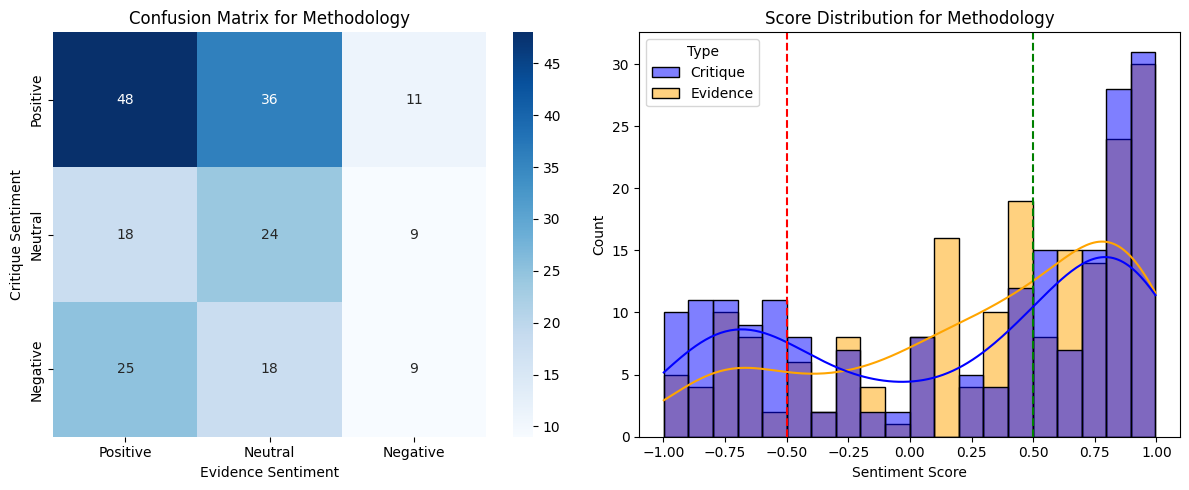

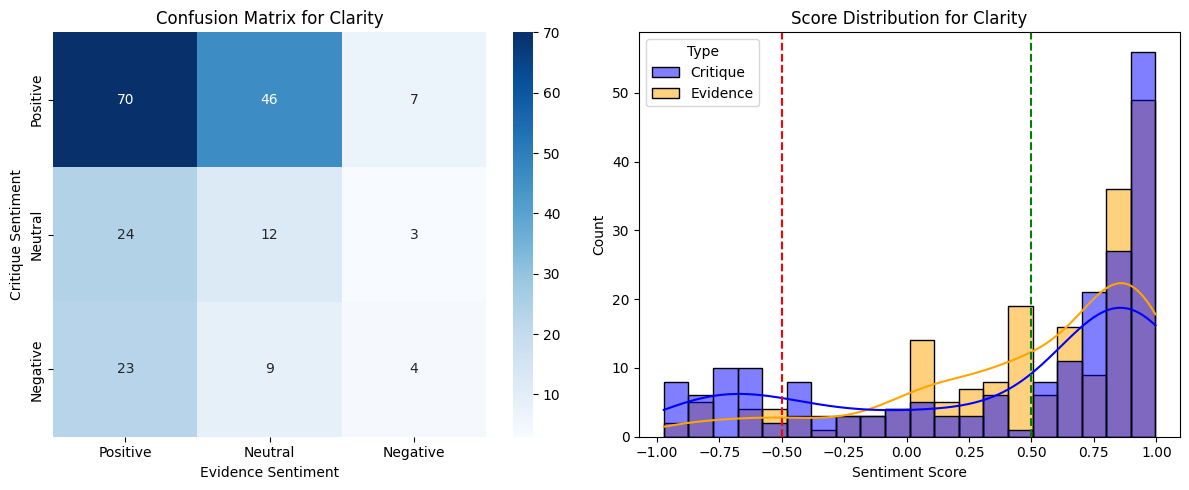

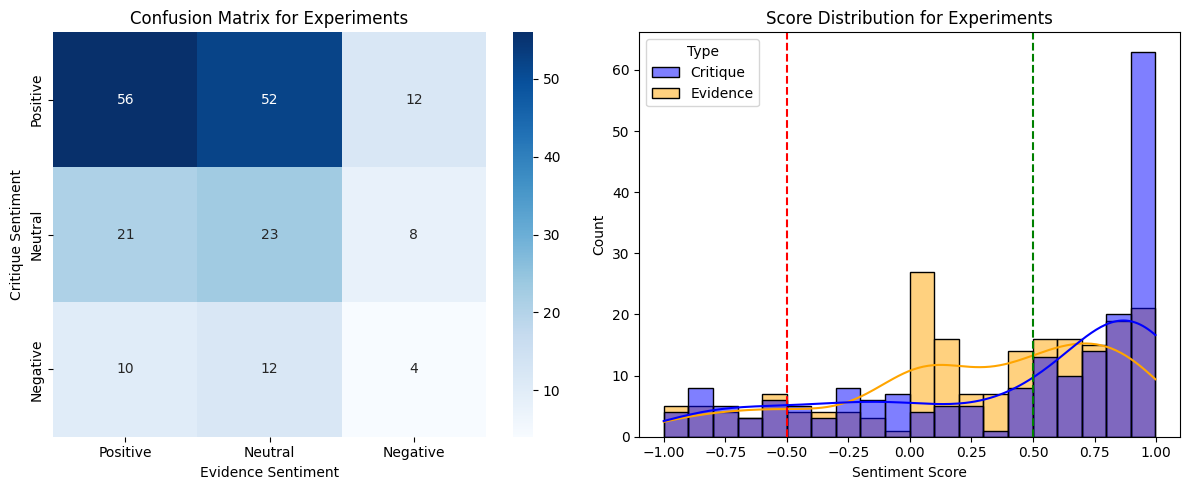

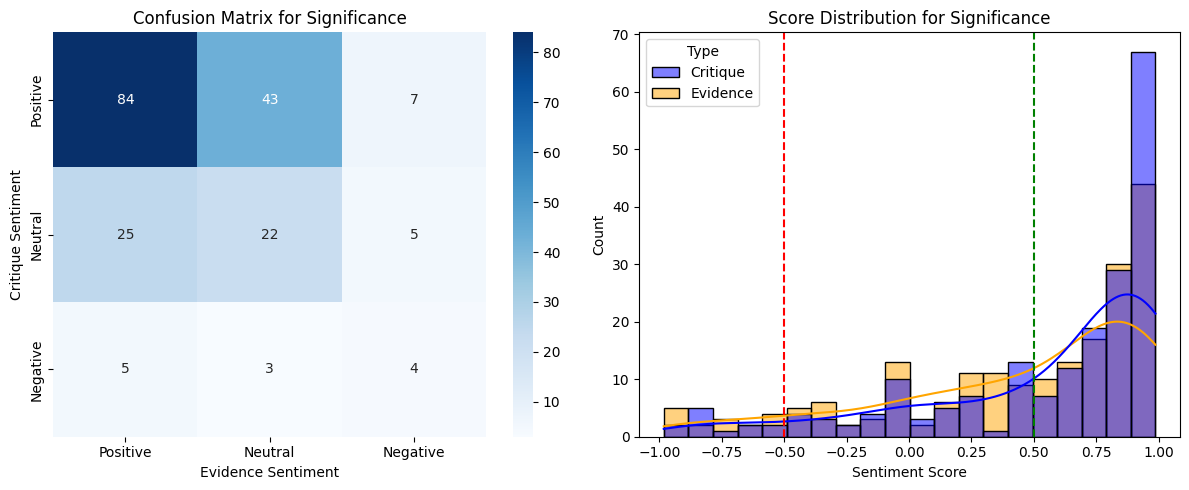

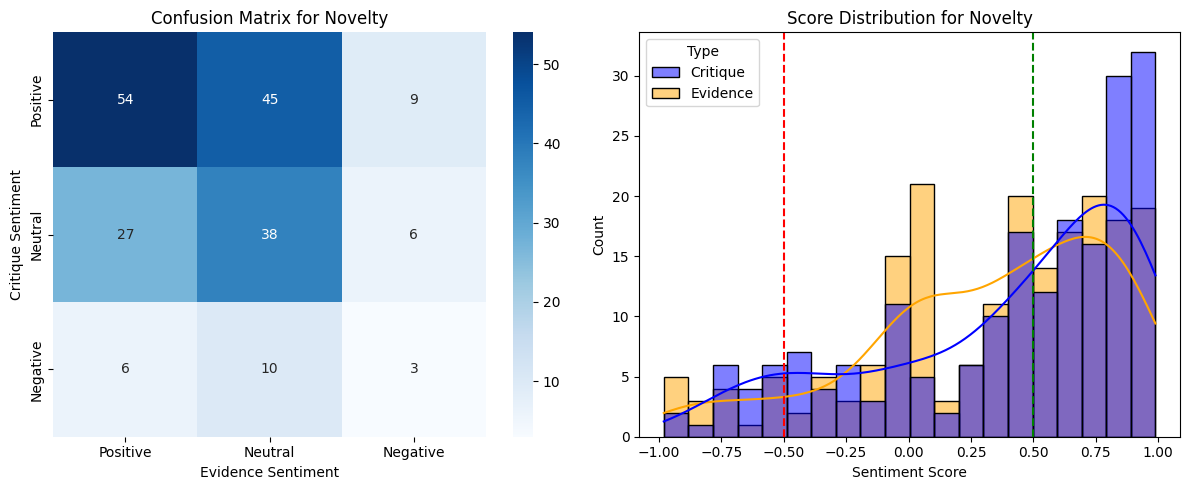

In [49]:
sentiment_order = ["Positive", "Neutral", "Negative"]

for section in sections:
    y_true = sentiment_critiques[f"{section}_sentiment"]
    y_pred = sentiment_evidences[f"{section}_sentiment"]
    
    critique_scores = scores_critiques[f"{section}_score"]
    evidence_scores = scores_evidences[f"{section}_score"]

    cm = confusion_matrix(y_true, y_pred, labels=sentiment_order)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sentiment_order, yticklabels=sentiment_order, ax=axes[0])
    axes[0].set_xlabel("Evidence Sentiment")
    axes[0].set_ylabel("Critique Sentiment")
    axes[0].set_title(f"Confusion Matrix for {section}")

    score_data = pd.DataFrame({
        "Scores": list(critique_scores) + list(evidence_scores),
        "Type": ["Critique"] * len(critique_scores) + ["Evidence"] * len(evidence_scores)
    })
    
    sns.histplot(data=score_data, x="Scores", hue="Type", bins=20, kde=True, ax=axes[1], palette={"Critique": "blue", "Evidence": "orange"})
    
    axes[1].axvline(-0.5, color='red', linestyle='--', linewidth=1.5, label="Negative Threshold")
    axes[1].axvline(0.5, color='green', linestyle='--', linewidth=1.5, label="Positive Threshold")

    axes[1].set_title(f"Score Distribution for {section}")
    axes[1].set_xlabel("Sentiment Score")

    plt.tight_layout()
    plt.show()

In [ ]:
# paper abstract vs sota results similarity analysis

# Analysis

### 1. SOTA Paper titles vs Real paper titles (hist)
Paper titles that is present in the dataset and which is found as  SOTA paper as retrieved evidence have higher cosine similarity meaning the semantics between the two match. This tells us, the papers that are retrieved as evidences in SOTA Results are highly related to the papers on which we search.

### 2. Critiques and Evidences Sub-Columns scores (combined kde)
There is high semantics match in all the sub domains except for the CLARITY. This indicates the retrieved evidence is very much related to the data present (Critique Points) in terms of meaning.

### 3. Jaccard Similarity (combined KDE)
Jaccard Similarity of all the critiques and evidences are very low. This indicates even though the semantics highly match, the wordings retrieved are very different when compared to critiques we have.

### 4. Tone analysis (hist)
Evidences and Critiques have high tone match when evaluated with TextBlob Sentiment Polarity.

### Sentiment Analysis (conf mat and hist)
No clear insights